In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

In [3]:
class DoubleConv(nn.Module):
	def __init__(self, in_, out_):
		super().__init__()
		self.double_conv  = nn.Sequential(
			nn.Conv2d(in_, out_, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_),
			nn.ReLU(inplace=True),
			nn.Conv2d(out_, out_, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_),
			nn.ReLU(inplace=True)
		)
	def forward(self, x):
		return self.double_conv(x)

In [4]:
class Down(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Down, self).__init__()
		self.conv = DoubleConv(in_channels, out_channels)
		self.pool = nn.MaxPool2d(2)

	def forward(self, x):
		down = self.conv(x)
		pool = self.pool(down)
		return down, pool

In [5]:
class Up(nn.Module):
	def __init__(self, in_, out_):
		super().__init__()
		self.up = nn.ConvTranspose2d(in_, in_//2, kernel_size=2, stride=2)
		self.conv = DoubleConv(in_, out_)
	def forward(self, x1, x2):
		x1 = self.up(x1)
		diffY = x2.size()[2] - x1.size()[2]
		diffX = x2.size()[3] - x1.size()[3]
		x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
						diffY // 2, diffY - diffY // 2])
		x = torch.cat([x2, x1], dim=1)
		out = self.conv(x)
		return out

In [6]:
class OutConv(nn.Module):
	def __init__(self, in_, out_):
		super(OutConv, self).__init__()
		self.conv = nn.Conv2d(in_, out_, kernel_size=1)

	def forward(self, x):
		return self.conv(x)

In [7]:
class UNet(nn.Module):
	def __init__(self, in_, out_):
		super().__init__()
		self.step_down = 64

		self.label_embed = nn.Linear(in_, 256 * 256)
		self.down_1 = Down(1, self.step_down)
		self.down_2 = Down(self.step_down, 2*self.step_down)
		self.down_3 = Down(2*self.step_down, 4*self.step_down)
		self.down_4 = Down(4*self.step_down, 8*self.step_down)

		self.neck = DoubleConv(8*self.step_down, 16*self.step_down)

		self.up_1 = Up(16*self.step_down, 8*self.step_down)
		self.up_2 = Up(8*self.step_down, 4*self.step_down)
		self.up_3 = Up(4*self.step_down, 2*self.step_down)
		self.up_4 = Up(2*self.step_down, self.step_down)

		self.out = OutConv(self.step_down, out_)
		self.tanh = nn.Tanh()

	def forward(self, x):
		# x shape: [batch_size, num_labels]
		x = self.label_embed(x)
		# Reshape to [batch_size, 1, 256, 256]
		x = x.view(-1, 1, 256, 256)

		down1, pool1 = self.down_1(x)
		down2, pool2 = self.down_2(pool1)
		down3, pool3 = self.down_3(pool2)
		down4, pool4 = self.down_4(pool3)

		neck = self.neck(pool4)

		up1 = self.up_1(neck, down4)
		up2 = self.up_2(up1, down3)
		up3 = self.up_3(up2, down2)
		up4 = self.up_4(up3, down1)

		out = self.out(up4)
		out = self.tanh(out)
		return out

In [7]:
from datasets import load_dataset

ds = load_dataset("nelorth/oxford-flowers")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7169
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1020
    })
})

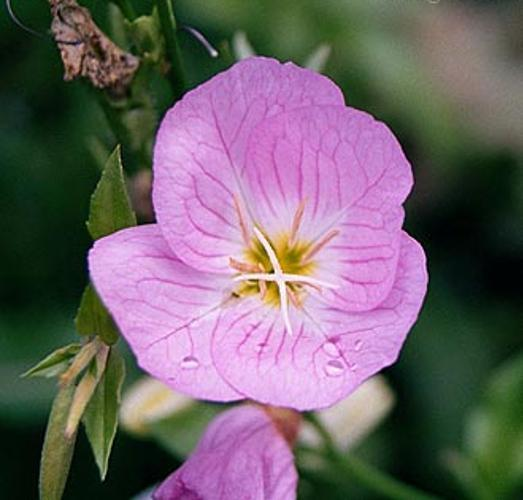

In [8]:
ds["train"][0]["image"]

In [9]:
ds["train"][0]["label"]

0

In [10]:
train_dataset = ds["train"]
test_dataset = ds["test"]

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

In [12]:
class ImageGenerationDataset(Dataset):
	def __init__(self, dataset, transform=None):
		self.dataset = dataset
		self.transform = transform or transforms.Compose([
			transforms.Resize((256, 256)),
			transforms.ToTensor(),
			transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
		])
		
		# Create label to index mapping
		self.label_to_idx = {label: idx for idx, label in enumerate(set(dataset['label']))}
		self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

	def __len__(self):
		return len(self.dataset)

	def __getitem__(self, idx):
		image = self.dataset[idx]['image']
		label = self.dataset[idx]['label']
		
		if not isinstance(image, Image.Image):
			image = Image.fromarray(image)
		
		if self.transform:
			image = self.transform(image)
		
		# Convert label to index
		label_idx = self.label_to_idx[label]
		label_tensor = torch.zeros(len(self.label_to_idx), dtype=torch.float32)
		label_tensor[label_idx] = 1.0
		
		return image, label_tensor

In [13]:
def create_dataloaders(train_dataset, test_dataset, batch_size=8, num_workers=0):
	train_dataset = ImageGenerationDataset(train_dataset)
	test_dataset = ImageGenerationDataset(test_dataset)

	train_loader = DataLoader(
		train_dataset,
		batch_size=batch_size,
		shuffle=True,
		num_workers=num_workers
	)

	test_loader = DataLoader(
		test_dataset,
		batch_size=batch_size,
		shuffle=False,
		num_workers=num_workers
	)

	return train_loader, test_loader, train_dataset.label_to_idx

In [14]:
train_loader, test_loader, label_to_idx = create_dataloaders(train_dataset, test_dataset)

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_model(model, epochs=25, lr=0.0001):
	criterion = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
	scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

	for epoch in tqdm(range(epochs)):
		model.train()
		
		for images, labels in train_loader:
			images, labels = images.to(device), labels.to(device)

			optimizer.zero_grad()
			generated_images = model(labels)
			loss = criterion(generated_images, images)
			loss.backward()
			optimizer.step()
		
		scheduler.step()
		print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
	print("Training finished!")

In [22]:
model = UNet(len(label_to_idx), 3).to(device)

num_params = sum(p.numel() for p in model.parameters())

# Print the number of parameters in a human-readable format with periods
print(f"Number of parameters: {num_params:,}".replace(',', '.'))

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params:,}".replace(',', '.'))

Number of parameters: 37.792.707
Number of trainable parameters: 37.792.707


In [23]:
train_model(model)

  4%|▍         | 1/25 [04:10<1:40:06, 250.27s/it]

Epoch [1/25], Loss: 0.2324


  8%|▊         | 2/25 [08:48<1:42:12, 266.61s/it]

Epoch [2/25], Loss: 0.2587


 12%|█▏        | 3/25 [13:32<1:40:46, 274.82s/it]

Epoch [3/25], Loss: 0.1726


 16%|█▌        | 4/25 [18:18<1:37:40, 279.09s/it]

Epoch [4/25], Loss: 0.2834


 20%|██        | 5/25 [23:05<1:33:57, 281.87s/it]

Epoch [5/25], Loss: 0.2669


 24%|██▍       | 6/25 [28:09<1:31:41, 289.55s/it]

Epoch [6/25], Loss: 0.1930


 28%|██▊       | 7/25 [32:37<1:24:43, 282.43s/it]

Epoch [7/25], Loss: 0.2725


 32%|███▏      | 8/25 [37:01<1:18:21, 276.53s/it]

Epoch [8/25], Loss: 0.1230


 36%|███▌      | 9/25 [41:25<1:12:41, 272.60s/it]

Epoch [9/25], Loss: 0.3248


 40%|████      | 10/25 [45:49<1:07:28, 269.93s/it]

Epoch [10/25], Loss: 0.4841


 44%|████▍     | 11/25 [50:13<1:02:33, 268.10s/it]

Epoch [11/25], Loss: 0.2008


 48%|████▊     | 12/25 [54:37<57:50, 266.99s/it]  

Epoch [12/25], Loss: 0.1740


 52%|█████▏    | 13/25 [59:30<54:56, 274.70s/it]

Epoch [13/25], Loss: 0.2616


 52%|█████▏    | 13/25 [1:03:21<58:29, 292.45s/it]


KeyboardInterrupt: 

In [16]:
def generate_image(model, label, label_to_idx, device='cuda'):
	model.eval()
	with torch.no_grad():
		# Convert label to index
		label_idx = label_to_idx[label]
		
		# Create a one-hot encoded tensor
		label_tensor = torch.zeros(len(label_to_idx), device=device)
		label_tensor[label_idx] = 1
		
		# Add batch dimension
		label_tensor = label_tensor.unsqueeze(0)
		
		# Generate image
		generated_image = model(label_tensor)
		
		# Convert to image
		generated_image = generated_image.squeeze().cpu().numpy()
		generated_image = (generated_image * 0.5 + 0.5) * 255
		generated_image = generated_image.transpose(1, 2, 0).astype(np.uint8)
		
		return Image.fromarray(generated_image)

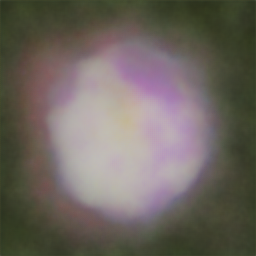

In [27]:
generate_image(model, 0, label_to_idx)

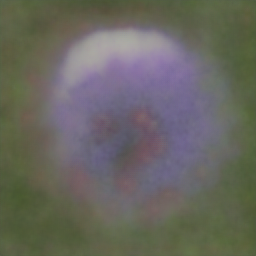

In [28]:
generate_image(model, 1, label_to_idx)

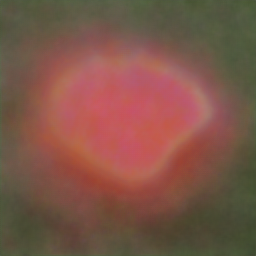

In [29]:
generate_image(model, 3, label_to_idx)

In [30]:
torch.save(model, "Unet-ImgGen.pth")

In [17]:
class UNet(nn.Module):
	def __init__(self, in_, out_):
		super().__init__()
		self.step_down = 64

		self.label_embed = nn.Linear(in_, 256 * 256)
		self.down_1 = Down(1, self.step_down)
		self.down_2 = Down(self.step_down, 2*self.step_down)
		self.down_3 = Down(2*self.step_down, 4*self.step_down)
		self.down_4 = Down(4*self.step_down, 8*self.step_down)
		self.down_5 = Down(8*self.step_down, 16*self.step_down)
		
		self.neck = DoubleConv(16*self.step_down, 32*self.step_down)

		self.up_1 = Up(32*self.step_down, 16*self.step_down)
		self.up_2 = Up(16*self.step_down, 8*self.step_down)
		self.up_3 = Up(8*self.step_down, 4*self.step_down)
		self.up_4 = Up(4*self.step_down, 2*self.step_down)
		self.up_5 = Up(2*self.step_down, self.step_down)

		self.out = OutConv(self.step_down, out_)
		self.tanh = nn.Tanh()

	def forward(self, x):
		# x shape: [batch_size, num_labels]
		x = self.label_embed(x)
		# Reshape to [batch_size, 1, 256, 256]
		x = x.view(-1, 1, 256, 256)

		down1, pool1 = self.down_1(x)
		down2, pool2 = self.down_2(pool1)
		down3, pool3 = self.down_3(pool2)
		down4, pool4 = self.down_4(pool3)
		down5, pool5 = self.down_5(pool4)

		neck = self.neck(pool5)

		up1 = self.up_1(neck, down5)
		up2 = self.up_2(up1, down4)
		up3 = self.up_3(up2, down3)
		up4 = self.up_4(up3, down2)
		up5 = self.up_5(up4, down1)

		out = self.out(up5)
		out = self.tanh(out)
		return out

In [18]:
model = UNet(len(label_to_idx), 3).to(device)

num_params = sum(p.numel() for p in model.parameters())

# Print the number of parameters in a human-readable format with periods
print(f"Number of parameters: {num_params:,}".replace(',', '.'))

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params:,}".replace(',', '.'))

Number of parameters: 131.135.427
Number of trainable parameters: 131.135.427


In [19]:
train_model(model)

  4%|▍         | 1/25 [05:30<2:12:13, 330.55s/it]

Epoch [1/25], Loss: 0.2686


  8%|▊         | 2/25 [11:17<2:10:19, 339.96s/it]

Epoch [2/25], Loss: 0.3840


 12%|█▏        | 3/25 [18:56<2:24:36, 394.39s/it]

Epoch [3/25], Loss: 0.1509


 16%|█▌        | 4/25 [26:29<2:26:09, 417.59s/it]

Epoch [4/25], Loss: 0.1957


 20%|██        | 5/25 [33:48<2:21:47, 425.37s/it]

Epoch [5/25], Loss: 0.2981


 24%|██▍       | 6/25 [40:39<2:13:06, 420.32s/it]

Epoch [6/25], Loss: 0.1629


 28%|██▊       | 7/25 [46:44<2:00:42, 402.35s/it]

Epoch [7/25], Loss: 0.1825


 32%|███▏      | 8/25 [52:11<1:47:15, 378.53s/it]

Epoch [8/25], Loss: 0.1755


 36%|███▌      | 9/25 [57:39<1:36:41, 362.58s/it]

Epoch [9/25], Loss: 0.2773


 40%|████      | 10/25 [1:03:07<1:27:56, 351.75s/it]

Epoch [10/25], Loss: 0.1984


 40%|████      | 10/25 [1:05:53<1:38:50, 395.37s/it]


KeyboardInterrupt: 

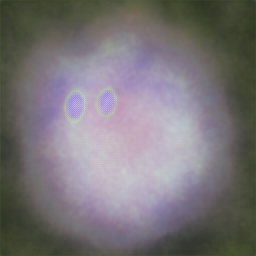

In [20]:
generate_image(model, 0, label_to_idx)

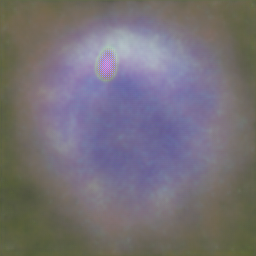

In [21]:
generate_image(model, 1, label_to_idx)

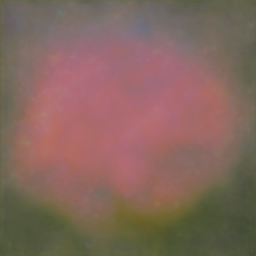

In [23]:
generate_image(model, 3, label_to_idx)